In [1]:
%load_ext autoreload
%autoreload 2
import tqdm
import numpy as np
import pandas as pd

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

from utils import *
from dataset import STDataset
from baseline import RandomRegionBaseline, TissueSpecificRandomRegionBaseline
from evaluate import Evaluator

from parameter import create_args
from models.common import get_linear_scheduler
from models.vae_gaussian import GaussianVAE
from models.vae_flow import FlowVAE
from models.ddpm import *

In [2]:
training_samples = generate_training_samples(num_samples_per_slice=1)

Seeding all randomness with seed=2024


In [3]:
tissue_distribution = count_dominant_tissue(training_samples)
print(tissue_distribution)

{'striatum': 1}


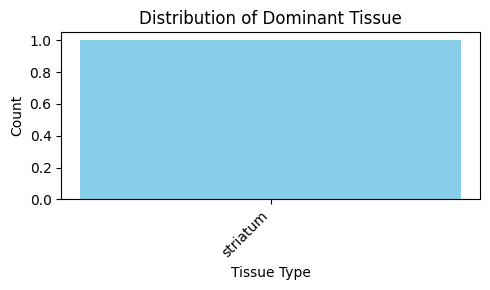

In [4]:
plot_tissue_distribution(tissue_distribution)

In [14]:
filter_training_samples = filter_training_sample_by_tissue(training_samples, tissue_name="striatum")

In [15]:
len(filter_training_samples)

125

In [5]:
tissue_index = {
    'striatum': 0,
    'cortical layer VI': 1,
    'cortical layer V': 2,
    'corpus callosum': 3,
    'cortical layer II/III': 4,
    'pia mater': 5
}


In [6]:
dataset = STDataset(training_samples)
# dataset = STDataset(filter_training_samples)
# Define a DataLoader to handle batching
# dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [8]:
n_epoch = 20
n_T = 400 # 500
device = "cuda:0"
lrate = 1e-4
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

ddpm = DDPM(nn_model=STModel(n_positions=2, n_features=374, n_tissues=6, device=device), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

In [10]:
for ep in range(n_epoch):
    print(f'Epoch {ep}')
    ddpm.train()

    # Linear learning rate decay
    optim.param_groups[0]['lr'] = lrate * (1 - ep / n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None  # Exponential moving average of the loss
    for batch in pbar:
        optim.zero_grad()

        # Extract positions, expressions, and tissue types from the batch
        positions = batch['positions'].to(device)
        expressions = batch['expressions'].to(device)
        # Assuming 'dominant_tissue' is coded as integers for indexing into embeddings
        tissue_types = batch['metadata']['dominant_tissue']  # This line might need adjustment based on actual encoding

        # Concatenate positions and expressions for the model input
        x = torch.cat((positions, expressions), dim=-1)

        # Generate a dummy tensor for context (tissue types), adjust as needed
        # For example, you might need to convert tissue types from strings to integers if not already
        c = torch.tensor([tissue_index[tissue] for tissue in tissue_types]).to(device)

        # Forward pass
        loss, noise, predicted_noise = ddpm(x, c)
        loss.backward()

        # Update loss EMA
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

        # Update progress bar
        pbar.set_description(f"Loss: {loss_ema:.4f}")

        optim.step()

    # Optionally, add validation or image saving code here


Epoch 0


Loss: 1.9488: 100%|██████████| 1/1 [00:00<00:00, 30.55it/s]


position loss: 0.8601347208023071 expression loss: 1.0886945724487305
Epoch 1


Loss: 2.2297: 100%|██████████| 1/1 [00:00<00:00, 112.76it/s]


position loss: 1.1502419710159302 expression loss: 1.0795050859451294
Epoch 2


Loss: 1.9181: 100%|██████████| 1/1 [00:00<00:00, 119.18it/s]


position loss: 0.8401119709014893 expression loss: 1.0779387950897217
Epoch 3


Loss: 2.0822: 100%|██████████| 1/1 [00:00<00:00, 119.00it/s]


position loss: 1.027677297592163 expression loss: 1.0545517206192017
Epoch 4


Loss: 1.9981: 100%|██████████| 1/1 [00:00<00:00, 122.96it/s]


position loss: 0.9367026090621948 expression loss: 1.0614473819732666
Epoch 5


Loss: 2.1742: 100%|██████████| 1/1 [00:00<00:00, 124.11it/s]


position loss: 1.0964142084121704 expression loss: 1.0777499675750732
Epoch 6


Loss: 2.0143: 100%|██████████| 1/1 [00:00<00:00, 123.05it/s]


position loss: 0.9674491882324219 expression loss: 1.0468145608901978
Epoch 7


Loss: 1.7526: 100%|██████████| 1/1 [00:00<00:00, 124.05it/s]


position loss: 0.6766349673271179 expression loss: 1.0759891271591187
Epoch 8


Loss: 1.9879: 100%|██████████| 1/1 [00:00<00:00, 121.60it/s]


position loss: 0.9126201272010803 expression loss: 1.0752793550491333
Epoch 9


Loss: 2.0923: 100%|██████████| 1/1 [00:00<00:00, 122.58it/s]


position loss: 1.0135756731033325 expression loss: 1.0786950588226318
Epoch 10


Loss: 2.1527: 100%|██████████| 1/1 [00:00<00:00, 122.49it/s]


position loss: 1.0797865390777588 expression loss: 1.0729179382324219
Epoch 11


Loss: 1.8677: 100%|██████████| 1/1 [00:00<00:00, 123.62it/s]


position loss: 0.7913554310798645 expression loss: 1.0763403177261353
Epoch 12


Loss: 2.0533: 100%|██████████| 1/1 [00:00<00:00, 125.38it/s]


position loss: 0.9977559447288513 expression loss: 1.0555394887924194
Epoch 13


Loss: 2.2651: 100%|██████████| 1/1 [00:00<00:00, 122.69it/s]


position loss: 1.1872620582580566 expression loss: 1.0778120756149292
Epoch 14


Loss: 2.1310: 100%|██████████| 1/1 [00:00<00:00, 123.12it/s]


position loss: 1.0626707077026367 expression loss: 1.0683677196502686
Epoch 15


Loss: 2.1611: 100%|██████████| 1/1 [00:00<00:00, 122.88it/s]


position loss: 1.057089924812317 expression loss: 1.1039754152297974
Epoch 16


Loss: 2.0006: 100%|██████████| 1/1 [00:00<00:00, 121.41it/s]


position loss: 0.922959566116333 expression loss: 1.077613115310669
Epoch 17


Loss: 1.9637: 100%|██████████| 1/1 [00:00<00:00, 123.69it/s]


position loss: 0.8995869159698486 expression loss: 1.0641580820083618
Epoch 18


Loss: 1.8863:   0%|          | 0/1 [00:00<?, ?it/s]

position loss: 0.8278281688690186 expression loss: 1.0584982633590698


Loss: 1.8863: 100%|██████████| 1/1 [00:00<00:00, 125.52it/s]


Epoch 19


Loss: 1.9286: 100%|██████████| 1/1 [00:00<00:00, 120.43it/s]

position loss: 0.8761769533157349 expression loss: 1.0524095296859741


In [11]:
noise, predicted_noise

(tensor([[[ 1.9263,  0.2715,  0.8240,  ...,  0.4464, -1.3039, -1.7271],
          [-0.8197, -0.0710,  0.7984,  ...,  0.5889, -1.6013,  0.1976],
          [-0.5162, -0.5854,  0.5279,  ...,  0.5317, -0.3844,  1.8515],
          ...,
          [-0.8661, -1.0417,  0.5678,  ...,  0.1218,  1.1905,  0.4543],
          [ 1.5326,  0.6228, -0.3223,  ...,  0.9833, -0.4401,  0.9108],
          [-0.4402,  1.1277,  1.0124,  ...,  0.7819,  0.8948, -0.7658]]],
        device='cuda:0'),
 tensor([[[ 7.9622e-02,  4.0176e-02,  1.3904e-01,  ...,  6.0368e-02,
           -1.7750e-01,  8.6198e-02],
          [ 1.8619e-02, -8.2049e-03,  2.1265e-01,  ...,  1.6216e-01,
           -2.4983e-01,  1.9754e-01],
          [ 1.3943e-01, -1.8676e-02,  1.7447e-01,  ...,  1.6658e-01,
           -1.8316e-01,  2.3128e-01],
          ...,
          [ 1.1125e-01, -2.0203e-01,  2.2600e-01,  ...,  3.8332e-01,
           -2.3087e-01,  2.2376e-01],
          [ 2.8054e-02, -5.0093e-05,  8.3798e-02,  ...,  4.2396e-02,
           -1

In [17]:
# Initialize dictionaries to store metrics for both baselines
metrics = {
    'Diffusion': {
        'mse': [],
        'f1': [],
        'cosine_sim': [],
        'chamfer_dist': [],
        'emd': []
    }
}

In [18]:
all_test_items = load_test_data(num_holes=10)

Seeding all randomness with seed=2024
Donor_id: MsBrainAgingSpatialDonor_1
Slice_id: 0
Donor_id: MsBrainAgingSpatialDonor_2
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_3
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_4
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_5
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_6
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_7
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_8
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_9
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_10
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_11
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_12
Slice_id: 0
Slice_id: 1


In [25]:
for i, test_item in enumerate(all_test_items):
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    
    test_tissue_index = tissue_index[test_item.test_area.dominant_tissue]
    
    with torch.no_grad():
        x = ddpm.sample_single(test_tissue_index)
        
    break

Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Step 1/400, Sample Shape: torch.Size([1, 50, 376])
Step 2/400, Sample Shape: torch.Size([1, 50, 376])
Step 3/400, Sample Shape: torch.Size([1, 50, 376])
Step 4/400, Sample Shape: torch.Size([1, 50, 376])
Step 5/400, Sample Shape: torch.Size([1, 50, 376])
Step 6/400, Sample Shape: torch.Size([1, 50, 376])
Step 7/400, Sample Shape: torch.Size([1, 50, 376])
Step 8/400, Sample Shape: torch.Size([1, 50, 376])
Step 9/400, Sample Shape: torch.Size([1, 50, 376])
Step 10/400, Sample Shape: torch.Size([1, 50, 376])
Step 11/400, Sample Shape: torch.Size([1, 50, 376])
Step 12/400, Sample Shape: torch.Size([1, 50, 376])
Step 13/400, Sample Shape: torch.Size([1, 50, 376])
Step 14/400, Sample Shape: torch.Size([1, 50, 376])
Step 15/400, Sample Shape: torch.Size([1, 50, 376])
Step 16/400, Sample Shape: torch.Size([1, 50, 376])
Step 17/400, Sample Shape: torch.Size([1, 50, 376])
Step 18/400, Sample Shape: torch.Size([1, 50, 

0

In [27]:
for i, test_item in enumerate(all_test_items):
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    
    test_tissue_index = tissue_index[test_item.test_area.dominant_tissue]
    
    with torch.no_grad():
        x = ddpm.sample_single(test_tissue_index)

    true_coords = test_item.ground_truth.hole_cells[['center_x', 'center_y']].values
    true_gene_expressions = test_item.ground_truth.gene_expression

    pred_coords, pred_gene_expressions = x[:,:2].cpu().numpy(), x[:,2:].cpu().numpy()

    mse_r, f1_r, cosine_sim_r = Evaluator.evaluate_expression(true_coords, true_gene_expressions, pred_coords, pred_gene_expressions)
    chamfer_dist_r = Evaluator.chamfer_distance(true_coords, pred_coords)
    emd_r = Evaluator.calculate_emd(true_coords, pred_coords)
    
    # Collect results for RandomRegionBaseline
    metrics['Diffusion']['mse'].append(mse_r)
    metrics['Diffusion']['f1'].append(f1_r)
    metrics['Diffusion']['cosine_sim'].append(cosine_sim_r)
    metrics['Diffusion']['chamfer_dist'].append(chamfer_dist_r)
    metrics['Diffusion']['emd'].append(emd_r)
        

Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 2:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 3:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 4:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 5:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 6:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 7:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 8:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 9:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 10:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 11:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 12:
  Dominant Tissue: corpus callosum
  Number of cells in groun

In [29]:
for method in metrics:
    print(f"Results for {method}:")
    for metric in metrics[method]:
        mean_value = np.mean(metrics[method][metric])
        std_value = np.std(metrics[method][metric])
        print(f"  {metric.capitalize()}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")

Results for Diffusion:
  Mse: Mean = 133.7422, Std = 3.6864
  F1: Mean = 0.4806, Std = 0.0253
  Cosine_sim: Mean = 0.0005, Std = 0.0158
  Chamfer_dist: Mean = 9334.3917, Std = 3861.8560
  Emd: Mean = 4729.6487, Std = 1930.9434


In [31]:
pred_coords

array([[ 18.89246   ,  -7.8724885 ],
       [  3.269108  ,   2.5687957 ],
       [  0.62583494,  -8.384888  ],
       [ -5.341048  ,  14.861167  ],
       [ -1.92481   ,  -7.6973968 ],
       [ -0.07300501,  10.406919  ],
       [  9.232348  ,  -3.1947715 ],
       [ 12.027211  ,  -3.1064465 ],
       [ 11.359305  ,  -7.851377  ],
       [ 10.968288  , -14.891005  ],
       [  8.740383  ,  -1.2143338 ],
       [-21.773565  ,   0.974317  ],
       [-11.692947  ,   4.405701  ],
       [ 15.088957  , -20.625978  ],
       [-15.567964  ,  16.817184  ],
       [ -4.137413  , -13.010883  ],
       [ 23.590746  ,  -8.371495  ],
       [ 14.34189   ,  -4.850592  ],
       [ -4.5174174 ,  -8.73691   ],
       [-14.390679  ,  10.583577  ],
       [ -1.1503048 ,  -6.626029  ],
       [  2.5693953 , -10.742705  ],
       [  3.4566798 ,  -1.7911329 ],
       [ 13.862366  , -10.5903015 ],
       [ -8.057493  ,  16.51877   ],
       [-12.454074  ,   7.467543  ],
       [ 13.068814  ,  -0.037971  ],
 

In [30]:
true_coords, true_gene_expressions, pred_coords, pred_gene_expressions

(array([[  1574.13703701, -10953.75719899],
        [  1490.38553421, -11037.68719697],
        [  1565.30803722, -10973.15919852],
        [  1627.71053572, -10946.89019915],
        [  1570.92153709, -11030.54769714],
        [  1593.10303655, -10955.61019894],
        [  1540.72853781, -11030.05719715],
        [  1523.17953824, -10953.53919899],
        [  1645.2050353 , -10943.51119924],
        [  1647.22153525, -11078.017196  ],
        [  1624.76753579, -11012.50819758],
        [  1558.98603737, -10967.43669866],
        [  1554.95303747, -10934.79119945],
        [  1664.77053483, -10973.70419851],
        [  1571.95703706, -10888.20869575],
        [  1529.82853808, -10946.07269917],
        [  1598.88003641, -11064.22869633],
        [  1565.41703722, -10896.27469556],
        [  1585.74553673, -11070.65969618],
        [  1557.67803741, -10928.79619959],
        [  1550.42953758, -11056.16269653],
        [  1671.20153467, -11047.66069673],
        [  1626.51153575, -10912

In [18]:
args = create_args()

In [42]:
if args.model == 'gaussian':
    model = GaussianVAE(args).to(args.device)
elif args.model == 'flow':
    model = FlowVAE(args).to(args.device)

In [43]:
model

GaussianVAE(
  (encoder): PointNetEncoder(
    (conv1): Conv1d(376, 32, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1_m): Linear(in_features=32, out_features=32, bias=True)
    (fc2_m): Linear(in_features=32, out_features=256, bias=True)
    (fc_bn1_m): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1_v): Linear(in_features=32, out_features=32, bias=True)
    (fc2_v): Linear(in_features=32, out_features=256, bias=True)
    (fc_bn1_v): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (diffusion): DiffusionPoint(
    (net): PointwiseNet(
      (layers): ModuleList(
        (0): ConcatSquashLinear(
          (_layer): Linear(in_features=376, out_features=128, bias=True)
          (_

In [44]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  390720


In [45]:
# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), 
    lr=args.lr, 
    weight_decay=args.weight_decay
)

scheduler = get_linear_scheduler(
    optimizer,
    start_epoch=args.sched_start_epoch,
    end_epoch=args.sched_end_epoch,
    start_lr=args.lr,
    end_lr=args.end_lr
)

In [46]:
for epoch in range(args.train_epochs):
    for batch in dataloader:
        positions = batch['positions']
        expressions = batch['expressions']
        metadata = batch['metadata']
        
        # Use the positions, expressions for model training
        # The metadata could be used for logging, tracking, or conditioning if needed
        # print(positions.shape, expressions.shape)
        
        x = torch.cat((positions, expressions), dim=2).to(args.device)
        
        # Reset grad and model state
        optimizer.zero_grad()
        model.train()
        
        loss = model.get_loss(x)

        # Backward and optimize
        loss.backward()
        orig_grad_norm = clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        scheduler.step()
        
    #     break
    # break
            
    # print("epoch:", epoch, "loss:", loss.item())
    

loss_prior: 43.215293884277344 loss_recons: 1.428468108177185
loss_prior: 45.11161422729492 loss_recons: 1.4219812154769897
loss_prior: 40.19297409057617 loss_recons: 1.6297687292099
loss_prior: 38.26530838012695 loss_recons: 1.3491694927215576
loss_prior: 37.44154739379883 loss_recons: 1.4217432737350464
loss_prior: 34.441383361816406 loss_recons: 1.4384878873825073
loss_prior: 34.64091110229492 loss_recons: 1.3276280164718628
loss_prior: 33.862632751464844 loss_recons: 1.4400230646133423
loss_prior: 31.70770263671875 loss_recons: 1.5533256530761719
loss_prior: 29.685216903686523 loss_recons: 1.1273138523101807
loss_prior: 28.880537033081055 loss_recons: 1.2874871492385864
loss_prior: 25.32862663269043 loss_recons: 1.3613570928573608
loss_prior: 27.468555450439453 loss_recons: 1.2836376428604126
loss_prior: 23.109333038330078 loss_recons: 1.463850498199463
loss_prior: 20.107534408569336 loss_recons: 1.2300490140914917
loss_prior: 18.27768325805664 loss_recons: 1.561371922492981
loss_p

In [49]:
x.shape

torch.Size([1, 50, 376])

In [53]:
# Initialize dictionaries to store metrics for both baselines
metrics = {
    'Diffusion': {
        'mse': [],
        'f1': [],
        'cosine_sim': [],
        'chamfer_dist': [],
        'emd': []
    }
}

In [25]:
all_test_items = load_test_data(num_holes=10)

Seeding all randomness with seed=2024
Donor_id: MsBrainAgingSpatialDonor_1
Slice_id: 0
Donor_id: MsBrainAgingSpatialDonor_2
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_3
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_4
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_5
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_6
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_7
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_8
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_9
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_10
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_11
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_12
Slice_id: 0
Slice_id: 1


In [54]:
for i, test_item in enumerate(all_test_items):
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    
    with torch.no_grad():
        z = torch.randn([1, args.latent_dim]).to(args.device)
        x = model.sample(z, 50)

    true_coords = test_item.ground_truth.hole_cells[['center_x', 'center_y']].values
    true_gene_expressions = test_item.ground_truth.gene_expression

    pred_coords, pred_gene_expressions = x[0,:,:2].cpu().numpy(), x[0,:,2:].cpu().numpy()

    mse_r, f1_r, cosine_sim_r = Evaluator.evaluate_expression(true_coords, true_gene_expressions, pred_coords, pred_gene_expressions)
    chamfer_dist_r = Evaluator.chamfer_distance(true_coords, pred_coords)
    emd_r = Evaluator.calculate_emd(true_coords, pred_coords)
    
    # Collect results for RandomRegionBaseline
    metrics['Diffusion']['mse'].append(mse_r)
    metrics['Diffusion']['f1'].append(f1_r)
    metrics['Diffusion']['cosine_sim'].append(cosine_sim_r)
    metrics['Diffusion']['chamfer_dist'].append(chamfer_dist_r)
    metrics['Diffusion']['emd'].append(emd_r)
        

Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 2:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 3:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 4:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 5:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 6:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 7:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 8:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 9:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 10:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 11:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 12:
  Dominant Tissue: corpus callosum
  Number of cells in groun

In [55]:
for method in metrics:
    print(f"Results for {method}:")
    for metric in metrics[method]:
        mean_value = np.mean(metrics[method][metric])
        std_value = np.std(metrics[method][metric])
        print(f"  {metric.capitalize()}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")

Results for Diffusion:
  Mse: Mean = 1.4475, Std = 0.3142
  F1: Mean = 0.5508, Std = 0.0335
  Cosine_sim: Mean = 0.0066, Std = 0.0317
  Chamfer_dist: Mean = 9278.6375, Std = 3955.5474
  Emd: Mean = 4691.1569, Std = 1977.6617
